In [1]:
#Giải nén file
import zipfile
import os

zip_path = "animals-20250626T072843Z-1-001.zip"
extract_dir = "animals"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("Giải nén hoàn tất!")


Giải nén hoàn tất!


In [2]:
#Chọn 3 loại cat, dog, butterfly
import zipfile

class_list = ['cat', 'dog', 'butterfly']
for animal in class_list:
    zip_path = f"animals/animals/{animal}.zip"
    extract_dir = f"animals/animals/{animal}"
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
    print(f"Đã giải nén {animal}")


Đã giải nén cat
Đã giải nén dog
Đã giải nén butterfly


In [3]:
#Chuyển về 1 thư mục duy nhất "dataset/"
import shutil
import os

os.makedirs("dataset", exist_ok=True)

for animal in class_list:
    src_dir = f"animals/animals/{animal}/{animal}"
    dest_dir = f"dataset/{animal}"
    shutil.move(src_dir, dest_dir)

print("Đã chuẩn bị xong dataset!")


Đã chuẩn bị xong dataset!


In [4]:
#Load dữ liệu bằng ImageFolder
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

full_dataset = datasets.ImageFolder("dataset", transform=transform)

# 80% train, 20% val
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print(f"Số lượng ảnh train: {len(train_dataset)}, val: {len(val_dataset)}")


Số lượng ảnh train: 6914, val: 1729


In [5]:
#Mô hình CNN
import torch.nn as nn

class CNNModel(nn.Module):
    def __init__(self, num_classes=3):
        super(CNNModel, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 32 * 32, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x


In [6]:
#Train mô hình và dùng 5 epoch
import torch
import torch.optim as optim
from torch.nn import CrossEntropyLoss

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNModel().to(device)

criterion = CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train loop
for epoch in range(5):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}")


Epoch 1, Loss: 0.8276
Epoch 2, Loss: 0.6220
Epoch 3, Loss: 0.5564
Epoch 4, Loss: 0.4749
Epoch 5, Loss: 0.3966


In [18]:
#Đánh giá mô hình trên tập validation (test)
from sklearn.metrics import classification_report, accuracy_score
import torch

model.eval()  # Chuyển về chế độ đánh giá
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Đánh giá
print("Accuracy:", accuracy_score(all_labels, all_preds))
print(classification_report(all_labels, all_preds, target_names=full_dataset.classes))


Accuracy: 0.7819548872180451
              precision    recall  f1-score   support

   butterfly       0.84      0.85      0.85       432
         cat       0.53      0.46      0.49       305
         dog       0.82      0.85      0.84       992

    accuracy                           0.78      1729
   macro avg       0.73      0.72      0.73      1729
weighted avg       0.77      0.78      0.78      1729



In [19]:
#Lưu mô hình
torch.save(model.state_dict(), "cnn_model_animals.pth")
print("Đã lưu mô hình thành công.")


Đã lưu mô hình thành công.


Ảnh này được dự đoán là: cat


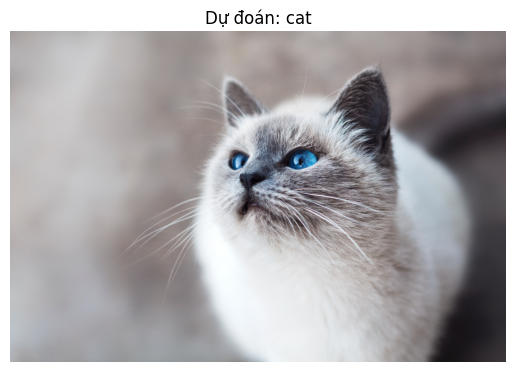

In [17]:
#Dự đoán
from PIL import Image
import matplotlib.pyplot as plt

def predict_image(image_path):
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)

    class_name = full_dataset.classes[predicted.item()]
    print(f"Ảnh này được dự đoán là: {class_name}")

    # Hiển thị ảnh
    img = Image.open(image_path)
    plt.imshow(img)
    plt.title(f"Dự đoán: {class_name}")
    plt.axis('off')
    plt.show()

predict_image("dataset/cat/mikhail-vasilyev-130018-unsplash.jpg")


In [16]:
#Load lại mô hình đã lưu
model = CNNModel().to(device)
model.load_state_dict(torch.load("cnn_model_animals.pth"))
model.eval()
print("Đã load lại mô hình thành công.")


Đã load lại mô hình thành công.
